In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from matplotlib import font_manager, rc, cm
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)
from sklearn.model_selection import train_test_split
import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Pycaret을 이용한 튜닝 및 예측
 - 3 표준편차 기준 이상치 대체 반응변수
 - 왜도 3 이상 값들 로그변환 설명변수
 - VIF < 11 인 값들
 - 부스팅 / 배깅 / 블랜딩 3개 혼합모델

#### 0. 데이터 불러오기
- stepwise로 선택된 변수
- 이상치가 대체된 배출량 data

In [2]:
data = pd.read_csv("행정동1 군집2번의 data 이상치 3.csv")
variable_dummy = np.load("행정동1 label 2 VIF10 선택변수.npy")
print(len(variable_dummy))
data.shape

16


(6385, 323)

In [3]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
data["내국인_목적별 0 교육여행"] = std.fit_transform(data["내국인_목적별 0 교육여행"].values.reshape(-1,1))
std = StandardScaler()
data["내국인_행태별 0 패키지"] = std.fit_transform(data["내국인_행태별 0 패키지"].values.reshape(-1,1))

성능평가 방법
- RMSLE

In [4]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def eval_reg(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print("RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE : {2:,.3f}".format(rmsle_val,rmse_val,mae_val))
    return rmsle_val,rmse_val,mae_val

#### 1. 데이터 생성하기
- 로그변환

In [5]:
Y = data["배출량"]
    
dummy = pd.get_dummies(data[["년","월","일","요일","분기"]],columns = ["년","월","일","요일","분기"]).columns
variable_nodummy = list(set(variable_dummy).difference(dummy))
# stepwise로 선택된 변수 중 dummy가 아닌 것들
    
select_dummy = list(set(variable_dummy).difference(variable_nodummy))
# stepwsie로 선택된 변수 중 dummy인 변수들
    
X_1 = pd.get_dummies(data.drop(["일자","행정시","배출량","행정동명"],axis=1)
                         ,columns=["년","월","일","요일","분기"])[variable_nodummy]
# X_1 : 더미변수를 제하고 stepwise로 선택된 모든 변수 dataframe

X_2 = pd.get_dummies(data.drop(["일자","행정시","배출량","행정동명"],axis=1)
                         ,columns=["년","월","일","요일","분기"])[select_dummy]
# X_2 : stepwise로 선택된 모든 더미변수 dataframe

loglist=[]
# 왜도 3인 설명변수 log1p 변환
for val in list(X_1.columns):
    if abs(X_1[val].skew())>3:
        X_1[val] = np.log1p(X_1[val])
        loglist.append(val)
        
X_1 = pd.DataFrame(X_1)
    
X_3 = data["행정동명"]
# Categorical Features인 행정동명
    
X = pd.concat([X_1,X_2,X_3],axis=1)
# X1, X2, X3 데이터 concat

x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, shuffle=True, random_state=0)
train = pd.concat([x_train, y_train], axis = 1)

reg = setup(data=train,
                target='배출량',
                numeric_imputation = 'mean',
                normalize = True,
                normalize_method = 'zscore',
                categorical_features = ["행정동명"],
                silent= True,
                fold_strategy = 'timeseries',
                fold = 3,
                session_id = 0,
                verbose=False)

단일 모델 선택하기 위한 성능 비교

In [8]:
best_5_d = compare_models(sort = 'RMSLE', n_select = 5)
print(best_5_d)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,305742.5345,182420278135.7045,426506.4424,0.6353,0.1357,0.0954,4.4233
rf,Random Forest Regressor,316616.2038,195894407325.7666,442539.2383,0.6086,0.1381,0.0976,1.4967
et,Extra Trees Regressor,328271.0107,214619732693.1654,463174.7855,0.5718,0.1428,0.1003,1.4333
gbr,Gradient Boosting Regressor,331080.4929,209551093259.6956,457664.6180,0.5813,0.1480,0.1053,1.6467
knn,K Neighbors Regressor,358432.4583,238391885824.0000,488076.9375,0.5240,0.1518,0.1103,0.2367
dt,Decision Tree Regressor,411294.2645,325990108430.7610,570918.7925,0.3483,0.1739,0.1229,0.1233
ada,AdaBoost Regressor,426186.8491,305209189773.2105,552211.9337,0.3915,0.1759,0.1354,0.6133
ridge,Ridge Regression,381408.6771,269866390869.3334,519464.9583,0.4610,0.1763,0.1257,9.5533
br,Bayesian Ridge,381187.4034,269795106779.2295,519393.9280,0.4612,0.1763,0.1257,0.0333
lasso,Lasso Regression,381640.1458,270008532992.0000,519603.3646,0.4607,0.1764,0.1257,10.7133


[LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False), ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, cri

#### (2)  모델 생성 및 튜닝 (단일 모델 3개 / 배깅 모델 3개 / 부스팅 3개 / 블렌딩 3개)
- RMSLE을 기준으로 상위 모델 선정 
- 단 다른 5개의 성능 지표 비교해서 결정

In [9]:
tuned_models = []

In [ ]:
### 상위 모델 1번 : Extra Tree Regressor
model_01 = create_model("et")

model_01 = tune_model(model_01, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_01)

In [10]:
### 상위 모델 2번 : Random Forest Regressor
model_02 = create_model("gbr")

model_02 = tune_model(model_02, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,336261.5149,204844361039.6170,452597.3498,0.6015,0.1396,0.1023
1,299290.4312,182312230346.1969,426980.3630,0.6166,0.1337,0.0920
2,287699.0333,163290422271.4875,404092.0963,0.6824,0.1289,0.0892
Mean,307750.3265,183482337885.7671,427889.9363,0.6335,0.1341,0.0945
SD,20708.3884,16984489405.0814,19812.6289,0.0351,0.0044,0.0056


In [11]:
#  Light Gradient Boosting Machine 튜닝 (상위 모델 3번)
model_03 = create_model('lightgbm')

model_03 = tune_model(model_03, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,325748.5929,196697162675.2928,443505.5385,0.6174,0.1378,0.0999
1,295674.8382,174593399536.4729,417843.7501,0.6328,0.1303,0.0905
2,269800.8917,146645410483.2941,382943.0904,0.7147,0.1255,0.0856
Mean,297074.7743,172645324231.6866,414764.1263,0.6550,0.1312,0.0920
SD,22861.9944,20479920612.1044,24820.2282,0.0427,0.0050,0.0059


배깅

In [12]:
prediction_models = []

bag_01_15 = ensemble_model(model_01 , n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_01_15)

bag_02_15 = ensemble_model(model_02, n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_02_15 )

bag_03_15 = ensemble_model(model_03, n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_03_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,320700.2255,189175245963.4346,434942.8077,0.6320,0.1372,0.0996
1,288797.3595,171336521552.0668,413928.1599,0.6397,0.1313,0.0897
2,275749.0042,150543953797.3257,387999.9405,0.7072,0.1290,0.0886
Mean,295082.1964,170351907104.2757,412290.3027,0.6596,0.1325,0.0926
SD,18881.6923,15786519202.8709,19199.3078,0.0338,0.0034,0.0050


부스팅

In [13]:
boo_01 = ensemble_model(model_01, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_01)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,332795.6434,204944418594.1534,452707.8734,0.6014,0.1388,0.1013
1,314110.2330,199325939411.9328,446459.3368,0.5808,0.1392,0.0971
2,325274.7051,211320060706.6730,459695.6175,0.5889,0.1446,0.1006
Mean,324060.1938,205196806237.5864,452954.2759,0.5904,0.1409,0.0996
SD,7676.4757,4899830680.7585,5406.4971,0.0085,0.0026,0.0019


In [14]:
boo_02 = ensemble_model(model_02, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,325671.1906,193253654817.6685,439606.2497,0.6241,0.1372,0.1004
1,298875.9119,179662811239.0123,423866.5017,0.6221,0.1336,0.0925
2,296241.1708,171081597867.5649,413620.1130,0.6672,0.1350,0.0938
Mean,306929.4244,181332687974.7486,425697.6215,0.6378,0.1352,0.0956
SD,13296.0098,9128395024.4671,10687.5184,0.0208,0.0015,0.0035


In [15]:
boo_03 = ensemble_model(model_03, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,327185.2465,193121048911.6435,439455.4004,0.6243,0.1377,0.1011
1,295074.8620,173878220444.1831,416987.0747,0.6343,0.1315,0.0912
2,285473.3849,162489258398.9055,403099.5639,0.6839,0.1330,0.0911
Mean,302577.8311,176496175918.2440,419847.3463,0.6475,0.1341,0.0945
SD,17836.1199,12641648512.0201,14979.3764,0.0261,0.0026,0.0047


블렌딩

In [16]:
blend_3_soft = blend_models(estimator_list=[model_01, model_02, model_03], fold=3, optimize='RMSLE')
prediction_models.append(blend_3_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,315334.8595,189917268327.8684,435794.9843,0.6306,0.1337,0.0959
1,291540.0636,174353281184.3252,417556.3210,0.6333,0.1307,0.0898
2,280986.8747,160857954974.8356,401071.0099,0.6871,0.1286,0.0878
Mean,295953.9326,175042834829.0097,418140.7717,0.6503,0.1310,0.0912
SD,14365.6464,11873430740.0771,14182.0259,0.0260,0.0021,0.0035


#### 생성된 모델에 대한 Train 데이터에 대한 성과 확인

In [17]:
for model in tuned_models:
    print(model.__class__.__name__)
    display(predict_model(model))

GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,278717.8541,153374002433.6582,391629.9305,0.7023,0.1246,0.0869


,월배출량비율,CO,월별예상승객총합,평균 기온,일강수량,연_월부페결제건수비율,내국인_목적별 0 교육여행,지방소득세,내국인_행태별 0 패키지,장기4일표준편차,...,요일간식결제건수비율,연배출금액편차,연휴전날_0.6931471824645996,행정동명_동홍동,행정동명_삼양동,행정동명_아라동,행정동명_외도동,행정동명_화북동,배출량,Label
0,0.117831,1.061249,-0.206142,-1.035563,-0.507419,0.134242,-0.459666,-0.417159,-0.717831,-0.664463,...,-0.611103,-0.056170,0.0,0.0,0.0,0.0,1.0,0.0,2875400.0,3.051393e+06
1,0.098644,-0.222900,-0.662380,-0.940588,0.466079,-0.422502,0.239650,-0.554055,0.049992,1.510380,...,1.675480,-0.925236,0.0,0.0,0.0,1.0,0.0,0.0,4135550.0,3.814542e+06
2,0.141530,0.025297,1.180869,-1.211946,-0.507419,-0.173409,-0.564651,-0.429021,-0.723862,-0.733379,...,-0.313924,-0.546564,0.0,0.0,1.0,0.0,0.0,0.0,3451900.0,3.463317e+06
3,-0.445631,-0.825664,1.908726,0.266956,1.676700,-1.616912,-0.561225,0.324440,-0.808537,0.070281,...,-1.450634,0.362467,0.0,1.0,0.0,0.0,0.0,0.0,2514100.0,2.802603e+06
4,-0.146893,0.486234,0.065055,0.375499,0.804723,-0.267105,-0.559513,0.340210,-0.858842,0.929570,...,-0.596465,0.084744,0.0,0.0,0.0,0.0,0.0,1.0,3389650.0,3.603979e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,0.258182,0.273494,0.228654,1.189574,1.717709,1.218796,-0.106989,-0.203098,0.025568,-0.454085,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,4122400.0,3.977986e+06
1529,-1.187238,0.450777,-0.142226,0.565450,-0.507419,1.407972,2.411798,-0.419773,1.825583,-0.328853,...,0.095952,-0.286826,0.0,0.0,1.0,0.0,0.0,0.0,4170350.0,3.577320e+06
1530,0.192991,-0.081073,-0.127585,-1.551144,-0.507419,0.227286,-0.554632,-0.391966,-0.302166,0.399535,...,0.886964,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3691250.0,3.932955e+06
1531,-0.146893,-0.542010,0.200006,0.728265,0.611517,1.981728,2.578781,0.248814,2.933343,-0.551452,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3284650.0,3.241775e+06


LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,254867.2522,136151786019.4867,368987.5147,0.7357,0.1181,0.0792


,월배출량비율,CO,월별예상승객총합,평균 기온,일강수량,연_월부페결제건수비율,내국인_목적별 0 교육여행,지방소득세,내국인_행태별 0 패키지,장기4일표준편차,...,요일간식결제건수비율,연배출금액편차,연휴전날_0.6931471824645996,행정동명_동홍동,행정동명_삼양동,행정동명_아라동,행정동명_외도동,행정동명_화북동,배출량,Label
0,0.117831,1.061249,-0.206142,-1.035563,-0.507419,0.134242,-0.459666,-0.417159,-0.717831,-0.664463,...,-0.611103,-0.056170,0.0,0.0,0.0,0.0,1.0,0.0,2875400.0,2.918168e+06
1,0.098644,-0.222900,-0.662380,-0.940588,0.466079,-0.422502,0.239650,-0.554055,0.049992,1.510380,...,1.675480,-0.925236,0.0,0.0,0.0,1.0,0.0,0.0,4135550.0,3.696703e+06
2,0.141530,0.025297,1.180869,-1.211946,-0.507419,-0.173409,-0.564651,-0.429021,-0.723862,-0.733379,...,-0.313924,-0.546564,0.0,0.0,1.0,0.0,0.0,0.0,3451900.0,3.372623e+06
3,-0.445631,-0.825664,1.908726,0.266956,1.676700,-1.616912,-0.561225,0.324440,-0.808537,0.070281,...,-1.450634,0.362467,0.0,1.0,0.0,0.0,0.0,0.0,2514100.0,2.908175e+06
4,-0.146893,0.486234,0.065055,0.375499,0.804723,-0.267105,-0.559513,0.340210,-0.858842,0.929570,...,-0.596465,0.084744,0.0,0.0,0.0,0.0,0.0,1.0,3389650.0,3.581250e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,0.258182,0.273494,0.228654,1.189574,1.717709,1.218796,-0.106989,-0.203098,0.025568,-0.454085,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,4122400.0,3.880890e+06
1529,-1.187238,0.450777,-0.142226,0.565450,-0.507419,1.407972,2.411798,-0.419773,1.825583,-0.328853,...,0.095952,-0.286826,0.0,0.0,1.0,0.0,0.0,0.0,4170350.0,3.851755e+06
1530,0.192991,-0.081073,-0.127585,-1.551144,-0.507419,0.227286,-0.554632,-0.391966,-0.302166,0.399535,...,0.886964,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3691250.0,3.772918e+06
1531,-0.146893,-0.542010,0.200006,0.728265,0.611517,1.981728,2.578781,0.248814,2.933343,-0.551452,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3284650.0,3.323518e+06


In [18]:
for model in prediction_models:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,289239.2980,176501603595.3868,420120.9392,0.6574,0.1312,0.0894


,월배출량비율,CO,월별예상승객총합,평균 기온,일강수량,연_월부페결제건수비율,내국인_목적별 0 교육여행,지방소득세,내국인_행태별 0 패키지,장기4일표준편차,...,요일간식결제건수비율,연배출금액편차,연휴전날_0.6931471824645996,행정동명_동홍동,행정동명_삼양동,행정동명_아라동,행정동명_외도동,행정동명_화북동,배출량,Label
0,0.117831,1.061249,-0.206142,-1.035563,-0.507419,0.134242,-0.459666,-0.417159,-0.717831,-0.664463,...,-0.611103,-0.056170,0.0,0.0,0.0,0.0,1.0,0.0,2875400.0,2.842205e+06
1,0.098644,-0.222900,-0.662380,-0.940588,0.466079,-0.422502,0.239650,-0.554055,0.049992,1.510380,...,1.675480,-0.925236,0.0,0.0,0.0,1.0,0.0,0.0,4135550.0,3.754871e+06
2,0.141530,0.025297,1.180869,-1.211946,-0.507419,-0.173409,-0.564651,-0.429021,-0.723862,-0.733379,...,-0.313924,-0.546564,0.0,0.0,1.0,0.0,0.0,0.0,3451900.0,2.935091e+06
3,-0.445631,-0.825664,1.908726,0.266956,1.676700,-1.616912,-0.561225,0.324440,-0.808537,0.070281,...,-1.450634,0.362467,0.0,1.0,0.0,0.0,0.0,0.0,2514100.0,2.865718e+06
4,-0.146893,0.486234,0.065055,0.375499,0.804723,-0.267105,-0.559513,0.340210,-0.858842,0.929570,...,-0.596465,0.084744,0.0,0.0,0.0,0.0,0.0,1.0,3389650.0,3.750567e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,0.258182,0.273494,0.228654,1.189574,1.717709,1.218796,-0.106989,-0.203098,0.025568,-0.454085,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,4122400.0,3.536775e+06
1529,-1.187238,0.450777,-0.142226,0.565450,-0.507419,1.407972,2.411798,-0.419773,1.825583,-0.328853,...,0.095952,-0.286826,0.0,0.0,1.0,0.0,0.0,0.0,4170350.0,3.306678e+06
1530,0.192991,-0.081073,-0.127585,-1.551144,-0.507419,0.227286,-0.554632,-0.391966,-0.302166,0.399535,...,0.886964,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3691250.0,3.918613e+06
1531,-0.146893,-0.542010,0.200006,0.728265,0.611517,1.981728,2.578781,0.248814,2.933343,-0.551452,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3284650.0,3.564489e+06


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,266582.6510,143703488457.9278,379082.4296,0.7211,0.1207,0.0830


,월배출량비율,CO,월별예상승객총합,평균 기온,일강수량,연_월부페결제건수비율,내국인_목적별 0 교육여행,지방소득세,내국인_행태별 0 패키지,장기4일표준편차,...,요일간식결제건수비율,연배출금액편차,연휴전날_0.6931471824645996,행정동명_동홍동,행정동명_삼양동,행정동명_아라동,행정동명_외도동,행정동명_화북동,배출량,Label
0,0.117831,1.061249,-0.206142,-1.035563,-0.507419,0.134242,-0.459666,-0.417159,-0.717831,-0.664463,...,-0.611103,-0.056170,0.0,0.0,0.0,0.0,1.0,0.0,2875400.0,2.982883e+06
1,0.098644,-0.222900,-0.662380,-0.940588,0.466079,-0.422502,0.239650,-0.554055,0.049992,1.510380,...,1.675480,-0.925236,0.0,0.0,0.0,1.0,0.0,0.0,4135550.0,3.809748e+06
2,0.141530,0.025297,1.180869,-1.211946,-0.507419,-0.173409,-0.564651,-0.429021,-0.723862,-0.733379,...,-0.313924,-0.546564,0.0,0.0,1.0,0.0,0.0,0.0,3451900.0,3.168431e+06
3,-0.445631,-0.825664,1.908726,0.266956,1.676700,-1.616912,-0.561225,0.324440,-0.808537,0.070281,...,-1.450634,0.362467,0.0,1.0,0.0,0.0,0.0,0.0,2514100.0,2.884665e+06
4,-0.146893,0.486234,0.065055,0.375499,0.804723,-0.267105,-0.559513,0.340210,-0.858842,0.929570,...,-0.596465,0.084744,0.0,0.0,0.0,0.0,0.0,1.0,3389650.0,3.690832e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,0.258182,0.273494,0.228654,1.189574,1.717709,1.218796,-0.106989,-0.203098,0.025568,-0.454085,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,4122400.0,3.768205e+06
1529,-1.187238,0.450777,-0.142226,0.565450,-0.507419,1.407972,2.411798,-0.419773,1.825583,-0.328853,...,0.095952,-0.286826,0.0,0.0,1.0,0.0,0.0,0.0,4170350.0,3.596262e+06
1530,0.192991,-0.081073,-0.127585,-1.551144,-0.507419,0.227286,-0.554632,-0.391966,-0.302166,0.399535,...,0.886964,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3691250.0,3.828956e+06
1531,-0.146893,-0.542010,0.200006,0.728265,0.611517,1.981728,2.578781,0.248814,2.933343,-0.551452,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3284650.0,3.422897e+06


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,256442.2549,136573426626.9679,369558.4211,0.7349,0.1181,0.0800


,월배출량비율,CO,월별예상승객총합,평균 기온,일강수량,연_월부페결제건수비율,내국인_목적별 0 교육여행,지방소득세,내국인_행태별 0 패키지,장기4일표준편차,...,요일간식결제건수비율,연배출금액편차,연휴전날_0.6931471824645996,행정동명_동홍동,행정동명_삼양동,행정동명_아라동,행정동명_외도동,행정동명_화북동,배출량,Label
0,0.117831,1.061249,-0.206142,-1.035563,-0.507419,0.134242,-0.459666,-0.417159,-0.717831,-0.664463,...,-0.611103,-0.056170,0.0,0.0,0.0,0.0,1.0,0.0,2875400.0,2.929550e+06
1,0.098644,-0.222900,-0.662380,-0.940588,0.466079,-0.422502,0.239650,-0.554055,0.049992,1.510380,...,1.675480,-0.925236,0.0,0.0,0.0,1.0,0.0,0.0,4135550.0,3.837584e+06
2,0.141530,0.025297,1.180869,-1.211946,-0.507419,-0.173409,-0.564651,-0.429021,-0.723862,-0.733379,...,-0.313924,-0.546564,0.0,0.0,1.0,0.0,0.0,0.0,3451900.0,3.214408e+06
3,-0.445631,-0.825664,1.908726,0.266956,1.676700,-1.616912,-0.561225,0.324440,-0.808537,0.070281,...,-1.450634,0.362467,0.0,1.0,0.0,0.0,0.0,0.0,2514100.0,2.922862e+06
4,-0.146893,0.486234,0.065055,0.375499,0.804723,-0.267105,-0.559513,0.340210,-0.858842,0.929570,...,-0.596465,0.084744,0.0,0.0,0.0,0.0,0.0,1.0,3389650.0,3.655290e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,0.258182,0.273494,0.228654,1.189574,1.717709,1.218796,-0.106989,-0.203098,0.025568,-0.454085,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,4122400.0,3.771158e+06
1529,-1.187238,0.450777,-0.142226,0.565450,-0.507419,1.407972,2.411798,-0.419773,1.825583,-0.328853,...,0.095952,-0.286826,0.0,0.0,1.0,0.0,0.0,0.0,4170350.0,3.676068e+06
1530,0.192991,-0.081073,-0.127585,-1.551144,-0.507419,0.227286,-0.554632,-0.391966,-0.302166,0.399535,...,0.886964,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3691250.0,3.833149e+06
1531,-0.146893,-0.542010,0.200006,0.728265,0.611517,1.981728,2.578781,0.248814,2.933343,-0.551452,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3284650.0,3.347239e+06


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,292700.3767,181059135896.8031,425510.4416,0.6486,0.1335,0.0905


,월배출량비율,CO,월별예상승객총합,평균 기온,일강수량,연_월부페결제건수비율,내국인_목적별 0 교육여행,지방소득세,내국인_행태별 0 패키지,장기4일표준편차,...,요일간식결제건수비율,연배출금액편차,연휴전날_0.6931471824645996,행정동명_동홍동,행정동명_삼양동,행정동명_아라동,행정동명_외도동,행정동명_화북동,배출량,Label
0,0.117831,1.061249,-0.206142,-1.035563,-0.507419,0.134242,-0.459666,-0.417159,-0.717831,-0.664463,...,-0.611103,-0.056170,0.0,0.0,0.0,0.0,1.0,0.0,2875400.0,2848336.500
1,0.098644,-0.222900,-0.662380,-0.940588,0.466079,-0.422502,0.239650,-0.554055,0.049992,1.510380,...,1.675480,-0.925236,0.0,0.0,0.0,1.0,0.0,0.0,4135550.0,3829021.000
2,0.141530,0.025297,1.180869,-1.211946,-0.507419,-0.173409,-0.564651,-0.429021,-0.723862,-0.733379,...,-0.313924,-0.546564,0.0,0.0,1.0,0.0,0.0,0.0,3451900.0,3016301.500
3,-0.445631,-0.825664,1.908726,0.266956,1.676700,-1.616912,-0.561225,0.324440,-0.808537,0.070281,...,-1.450634,0.362467,0.0,1.0,0.0,0.0,0.0,0.0,2514100.0,2793137.000
4,-0.146893,0.486234,0.065055,0.375499,0.804723,-0.267105,-0.559513,0.340210,-0.858842,0.929570,...,-0.596465,0.084744,0.0,0.0,0.0,0.0,0.0,1.0,3389650.0,3763887.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,0.258182,0.273494,0.228654,1.189574,1.717709,1.218796,-0.106989,-0.203098,0.025568,-0.454085,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,4122400.0,3543125.195
1529,-1.187238,0.450777,-0.142226,0.565450,-0.507419,1.407972,2.411798,-0.419773,1.825583,-0.328853,...,0.095952,-0.286826,0.0,0.0,1.0,0.0,0.0,0.0,4170350.0,3411418.500
1530,0.192991,-0.081073,-0.127585,-1.551144,-0.507419,0.227286,-0.554632,-0.391966,-0.302166,0.399535,...,0.886964,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3691250.0,3979329.800
1531,-0.146893,-0.542010,0.200006,0.728265,0.611517,1.981728,2.578781,0.248814,2.933343,-0.551452,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3284650.0,3558540.500


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,275432.8276,144500904020.0052,380132.7453,0.7195,0.1215,0.0857


,월배출량비율,CO,월별예상승객총합,평균 기온,일강수량,연_월부페결제건수비율,내국인_목적별 0 교육여행,지방소득세,내국인_행태별 0 패키지,장기4일표준편차,...,요일간식결제건수비율,연배출금액편차,연휴전날_0.6931471824645996,행정동명_동홍동,행정동명_삼양동,행정동명_아라동,행정동명_외도동,행정동명_화북동,배출량,Label
0,0.117831,1.061249,-0.206142,-1.035563,-0.507419,0.134242,-0.459666,-0.417159,-0.717831,-0.664463,...,-0.611103,-0.056170,0.0,0.0,0.0,0.0,1.0,0.0,2875400.0,3.095993e+06
1,0.098644,-0.222900,-0.662380,-0.940588,0.466079,-0.422502,0.239650,-0.554055,0.049992,1.510380,...,1.675480,-0.925236,0.0,0.0,0.0,1.0,0.0,0.0,4135550.0,3.850632e+06
2,0.141530,0.025297,1.180869,-1.211946,-0.507419,-0.173409,-0.564651,-0.429021,-0.723862,-0.733379,...,-0.313924,-0.546564,0.0,0.0,1.0,0.0,0.0,0.0,3451900.0,3.226432e+06
3,-0.445631,-0.825664,1.908726,0.266956,1.676700,-1.616912,-0.561225,0.324440,-0.808537,0.070281,...,-1.450634,0.362467,0.0,1.0,0.0,0.0,0.0,0.0,2514100.0,2.779982e+06
4,-0.146893,0.486234,0.065055,0.375499,0.804723,-0.267105,-0.559513,0.340210,-0.858842,0.929570,...,-0.596465,0.084744,0.0,0.0,0.0,0.0,0.0,1.0,3389650.0,3.693532e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,0.258182,0.273494,0.228654,1.189574,1.717709,1.218796,-0.106989,-0.203098,0.025568,-0.454085,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,4122400.0,3.856385e+06
1529,-1.187238,0.450777,-0.142226,0.565450,-0.507419,1.407972,2.411798,-0.419773,1.825583,-0.328853,...,0.095952,-0.286826,0.0,0.0,1.0,0.0,0.0,0.0,4170350.0,3.684610e+06
1530,0.192991,-0.081073,-0.127585,-1.551144,-0.507419,0.227286,-0.554632,-0.391966,-0.302166,0.399535,...,0.886964,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3691250.0,3.904961e+06
1531,-0.146893,-0.542010,0.200006,0.728265,0.611517,1.981728,2.578781,0.248814,2.933343,-0.551452,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3284650.0,3.354038e+06


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,262351.7168,139248196993.5386,373159.7473,0.7297,0.1200,0.0820


,월배출량비율,CO,월별예상승객총합,평균 기온,일강수량,연_월부페결제건수비율,내국인_목적별 0 교육여행,지방소득세,내국인_행태별 0 패키지,장기4일표준편차,...,요일간식결제건수비율,연배출금액편차,연휴전날_0.6931471824645996,행정동명_동홍동,행정동명_삼양동,행정동명_아라동,행정동명_외도동,행정동명_화북동,배출량,Label
0,0.117831,1.061249,-0.206142,-1.035563,-0.507419,0.134242,-0.459666,-0.417159,-0.717831,-0.664463,...,-0.611103,-0.056170,0.0,0.0,0.0,0.0,1.0,0.0,2875400.0,2.945013e+06
1,0.098644,-0.222900,-0.662380,-0.940588,0.466079,-0.422502,0.239650,-0.554055,0.049992,1.510380,...,1.675480,-0.925236,0.0,0.0,0.0,1.0,0.0,0.0,4135550.0,3.884035e+06
2,0.141530,0.025297,1.180869,-1.211946,-0.507419,-0.173409,-0.564651,-0.429021,-0.723862,-0.733379,...,-0.313924,-0.546564,0.0,0.0,1.0,0.0,0.0,0.0,3451900.0,3.213080e+06
3,-0.445631,-0.825664,1.908726,0.266956,1.676700,-1.616912,-0.561225,0.324440,-0.808537,0.070281,...,-1.450634,0.362467,0.0,1.0,0.0,0.0,0.0,0.0,2514100.0,2.976540e+06
4,-0.146893,0.486234,0.065055,0.375499,0.804723,-0.267105,-0.559513,0.340210,-0.858842,0.929570,...,-0.596465,0.084744,0.0,0.0,0.0,0.0,0.0,1.0,3389650.0,3.647907e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,0.258182,0.273494,0.228654,1.189574,1.717709,1.218796,-0.106989,-0.203098,0.025568,-0.454085,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,4122400.0,3.655184e+06
1529,-1.187238,0.450777,-0.142226,0.565450,-0.507419,1.407972,2.411798,-0.419773,1.825583,-0.328853,...,0.095952,-0.286826,0.0,0.0,1.0,0.0,0.0,0.0,4170350.0,3.841508e+06
1530,0.192991,-0.081073,-0.127585,-1.551144,-0.507419,0.227286,-0.554632,-0.391966,-0.302166,0.399535,...,0.886964,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3691250.0,3.850596e+06
1531,-0.146893,-0.542010,0.200006,0.728265,0.611517,1.981728,2.578781,0.248814,2.933343,-0.551452,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3284650.0,3.303337e+06


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,261457.5926,143463958833.7693,378766.3644,0.7215,0.1203,0.0813


,월배출량비율,CO,월별예상승객총합,평균 기온,일강수량,연_월부페결제건수비율,내국인_목적별 0 교육여행,지방소득세,내국인_행태별 0 패키지,장기4일표준편차,...,요일간식결제건수비율,연배출금액편차,연휴전날_0.6931471824645996,행정동명_동홍동,행정동명_삼양동,행정동명_아라동,행정동명_외도동,행정동명_화북동,배출량,Label
0,0.117831,1.061249,-0.206142,-1.035563,-0.507419,0.134242,-0.459666,-0.417159,-0.717831,-0.664463,...,-0.611103,-0.056170,0.0,0.0,0.0,0.0,1.0,0.0,2875400.0,2.929055e+06
1,0.098644,-0.222900,-0.662380,-0.940588,0.466079,-0.422502,0.239650,-0.554055,0.049992,1.510380,...,1.675480,-0.925236,0.0,0.0,0.0,1.0,0.0,0.0,4135550.0,3.713354e+06
2,0.141530,0.025297,1.180869,-1.211946,-0.507419,-0.173409,-0.564651,-0.429021,-0.723862,-0.733379,...,-0.313924,-0.546564,0.0,0.0,1.0,0.0,0.0,0.0,3451900.0,3.235310e+06
3,-0.445631,-0.825664,1.908726,0.266956,1.676700,-1.616912,-0.561225,0.324440,-0.808537,0.070281,...,-1.450634,0.362467,0.0,1.0,0.0,0.0,0.0,0.0,2514100.0,2.857245e+06
4,-0.146893,0.486234,0.065055,0.375499,0.804723,-0.267105,-0.559513,0.340210,-0.858842,0.929570,...,-0.596465,0.084744,0.0,0.0,0.0,0.0,0.0,1.0,3389650.0,3.638159e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,0.258182,0.273494,0.228654,1.189574,1.717709,1.218796,-0.106989,-0.203098,0.025568,-0.454085,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,4122400.0,3.789434e+06
1529,-1.187238,0.450777,-0.142226,0.565450,-0.507419,1.407972,2.411798,-0.419773,1.825583,-0.328853,...,0.095952,-0.286826,0.0,0.0,1.0,0.0,0.0,0.0,4170350.0,3.589856e+06
1530,0.192991,-0.081073,-0.127585,-1.551144,-0.507419,0.227286,-0.554632,-0.391966,-0.302166,0.399535,...,0.886964,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3691250.0,3.911924e+06
1531,-0.146893,-0.542010,0.200006,0.728265,0.611517,1.981728,2.578781,0.248814,2.933343,-0.551452,...,1.213300,0.188488,0.0,0.0,0.0,0.0,0.0,1.0,3284650.0,3.393025e+06


#### 최종 모델 결정 및 성능 평가(test) 
- 상위 모델 3개(일반적으로 단일 모델 1개 / 앙상블 모델 2개해서 적절하게 선택)
- 선택된 최종 모델 3개에 대한 Test 성능 평가
- 이후 3개의 모델에 대한 앙상블(평균)에 대해서 test 성능 평가 후 모델 결정

In [19]:
final_01 = finalize_model(model_02) # 성능 상위모델 1번: 단일모델 gbr
final_02 = finalize_model(boo_03) # 성능 상위모델 2번: 부스팅 gbr
final_03  = finalize_model(bag_03_15) # 성능 상위모델 3번: 부스팅 lgbm

In [20]:
print(loglist)

['일강수량', '연휴전날']


In [21]:
from sklearn.metrics import r2_score
value_list = [] # test를 통해 상위 3개의 모델에 대한 mse / r2값 확인 
for model in [final_01, final_02, final_03]:
    prediction_i = predict_model(model, data = x_test)
    y_pred_i = prediction_i['Label']
    
    value_list.append(y_pred_i)
    
    y = y_test
    rmsle_score = rmsle(y, y_pred_i)
    r2score = r2_score(y, y_pred_i)
    print("rmsle 값: {} // r2_score: {}".format(rmsle_score, r2score))


rmsle 값: 0.11269829202777307 // r2_score: 0.7424565740703798
rmsle 값: 0.10714999045509471 // r2_score: 0.7812869964175242
rmsle 값: 0.10729896536179351 // r2_score: 0.7794105685592174


In [23]:
from matplotlib import font_manager, rc, cm
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

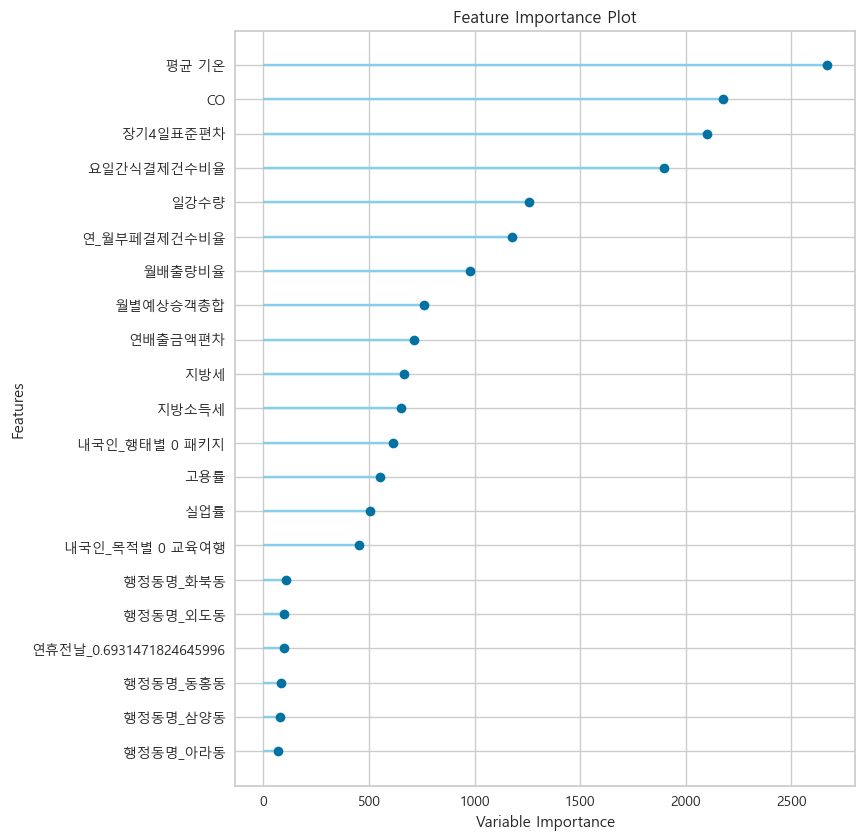

In [24]:
# 피쳐 중요도 확인
plot_model(final_02, 'feature_all' )

In [22]:


# 피쳐 중요도 확인
plot_model(final_02,"residuals" )

# q-q-plot
plot_model(final_02,"residuals_interactive")

    'data': [{'hovertemplate': 'Split=train<br>Predictions…